<a href="https://colab.research.google.com/github/finerbrighterlighter/myanmar_covid19/blob/master/exponential_growth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Libraries

In [1]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
from math import pi
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from google.colab import files
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Data

Since the Government fails to provide a complete and open dataset for disease status in the country, several young doctors in Myanmar volunteered on their own to monitor announcements. Current data applied is collected by Dr. Nyein Chan Ko Ko.

In [2]:
data = "https://raw.githubusercontent.com/finerbrighterlighter/myanmar_covid19/master/mohs_announcement.csv"
df = pd.read_csv(data,header= 0)
df.insert(loc=0, column="case_id", value=np.arange(1,len(df)+1))
df["case_id"] = "case_" + df["case_id"].astype(str)
df["first_date"] = pd.to_datetime(df["first_date"].values, utc=False).tz_localize("Asia/Yangon")
df["qua_date"] = pd.to_datetime(df["qua_date"].values, utc=False).tz_localize("Asia/Yangon")
df["ann_date"] = pd.to_datetime(df["ann_date"].values, utc=False).tz_localize("Asia/Yangon")
df["exp_date"] = pd.to_datetime(df["exp_date"].values, utc=False).tz_localize("Asia/Yangon")
df["dsc_date"] = pd.to_datetime(df["dsc_date"].values, utc=False).tz_localize("Asia/Yangon")
df

,case_id,age,sex,travel,region,first_date,qua_date,ann_date,exp_date,dsc_date
0,case_1,36,Male,United States,Chin,2020-03-15 00:00:00+06:30,2020-03-21 00:00:00+06:30,2020-03-23 00:00:00+06:30,NaT,NaT
1,case_2,26,Male,United Kingdom,Yangon,2020-03-22 00:00:00+06:30,2020-03-23 00:00:00+06:30,2020-03-23 00:00:00+06:30,NaT,NaT
2,case_3,26,Male,United Kingdom,Yangon,2020-03-21 00:00:00+06:30,2020-03-23 00:00:00+06:30,2020-03-25 00:00:00+06:30,NaT,NaT
3,case_4,33,Male,United States of America,Yangon,2020-03-19 00:00:00+06:30,2020-03-25 00:00:00+06:30,2020-03-27 00:00:00+06:30,NaT,2020-04-08 00:00:00+06:30
4,case_5,69,Male,Australia -> Singapore,Yangon,2020-03-14 00:00:00+06:30,2020-03-25 00:00:00+06:30,2020-03-27 00:00:00+06:30,2020-03-31 00:00:00+06:30,NaT
5,case_6,29,Male,United Kingdom,Yangon,2020-03-21 00:00:00+06:30,2020-03-26 00:00:00+06:30,2020-03-28 00:00:00+06:30,NaT,NaT
6,case_7,58,Female,Switzerland,Nay Pyi Taw,2020-03-18 00:00:00+06:30,2020-03-26 00:00:00+06:30,2020-03-28 00:00:00+06:30,NaT,2020-04-08 00:00:00+06:30
7,case_8,60,Female,NaN,Yangon,2020-03-25 00:00:00+06:30,2020-03-26 00:00:00+06:30,2020-03-28 00:00:00+06:30,NaT,NaT
8,case_9,44,Male,Thailand,Yangon,2020-03-23 00:00:00+06:30,2020-03-26 00:00:00+06:30,2020-03-29 00:00:00+06:30,NaT,NaT
9,case_10,45,Male,NaN,Yangon,2020-03-28 00:00:00+06:30,2020-03-28 00:00:00+06:30,2020-03-29 00:00:00+06:30,NaT,NaT


- travel -> travel history
- region -> states and admininstrative regions of Myanmar where the case is quarantined
- first_date -> entry into the country, or first symptom for no travel history
- qua_date -> first date of hospital quarantine
- ann_date -> date of announcement by MOHS as positive
- exp_date -> date of patient's death
- dsc_date -> date of discharge

# Basic Timeline ( Total cases, Daily new cases, infection spread)

In [3]:
case_df = df[["ann_date","travel"]].copy()
case_df.columns = ["date", "travel"]

case_df["overseas_inflow"] = np.where(df["travel"].isna(), 0, 1)
case_df["local_spread"] = np.where(df["travel"].notna(), 0, 1)
case_df["date"] = pd.to_datetime(case_df["date"])

case_df.drop("travel", axis=1 , inplace=True)
case_df=case_df.groupby(["date"]).sum().reset_index()

case_df

,date,overseas_inflow,local_spread
0,2020-03-23 00:00:00+06:30,2,0
1,2020-03-25 00:00:00+06:30,1,0
2,2020-03-27 00:00:00+06:30,2,0
3,2020-03-28 00:00:00+06:30,2,1
4,2020-03-29 00:00:00+06:30,1,1
5,2020-03-30 00:00:00+06:30,4,1
6,2020-04-01 00:00:00+06:30,0,1
7,2020-04-02 00:00:00+06:30,0,4
8,2020-04-04 00:00:00+06:30,1,0
9,2020-04-06 00:00:00+06:30,1,0


In [4]:
timeline_df = pd.DataFrame(columns=["ndays","date"])

timeline_df["ndays"] = np.arange(len(pd.date_range(start=df.ann_date.min(), end=pd.to_datetime("today").tz_localize("UTC").tz_convert("Asia/Yangon"))))
timeline_df.loc[0,"date"]=df.ann_date.min()
for i in range(1,len(timeline_df)):
    timeline_df.loc[i,"date"] = timeline_df.loc[i-1,"date"] + pd.Timedelta(days=1)
    i=i+1
timeline_df["date"] = pd.to_datetime(timeline_df["date"])

timeline_df=timeline_df.merge(case_df,indicator=False,how='left')
timeline_df["overseas_inflow"].fillna(0, inplace=True)
timeline_df["local_spread"].fillna(0, inplace=True)
timeline_df["overseas_inflow"]=timeline_df["overseas_inflow"].astype(int)
timeline_df["local_spread"]=timeline_df["local_spread"].astype(int)
timeline_df["total"] = (timeline_df["overseas_inflow"]+timeline_df["local_spread"]).cumsum().astype(int)
timeline_df

,ndays,date,overseas_inflow,local_spread,total
0,0,2020-03-23 00:00:00+06:30,2,0,2
1,1,2020-03-24 00:00:00+06:30,0,0,2
2,2,2020-03-25 00:00:00+06:30,1,0,3
3,3,2020-03-26 00:00:00+06:30,0,0,3
4,4,2020-03-27 00:00:00+06:30,2,0,5
5,5,2020-03-28 00:00:00+06:30,2,1,8
6,6,2020-03-29 00:00:00+06:30,1,1,10
7,7,2020-03-30 00:00:00+06:30,4,1,15
8,8,2020-03-31 00:00:00+06:30,0,0,15
9,9,2020-04-01 00:00:00+06:30,0,1,16


## Total Case

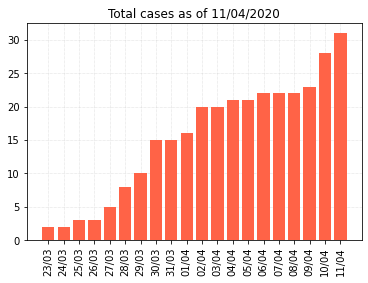

In [5]:
fig, ax = plt.subplots()
ax.grid(linestyle=':', linewidth='0.5', color='silver')
ax.set_axisbelow(True)


xindex = np.arange(len(pd.date_range(start=timeline_df.date.min(), end=pd.to_datetime("today").tz_localize("UTC").tz_convert("Asia/Yangon"))))


plt.xticks(xindex,pd.date_range(start=timeline_df.date.min(), end=pd.to_datetime("today").tz_localize("UTC").tz_convert("Asia/Yangon")).strftime('%d/%m'), fontsize=10, rotation=90)
plt.gca().yaxis.set_major_locator(mticker.MultipleLocator(5))

plt.bar(xindex, timeline_df["total"], color = "tomato")
plt.title("Total cases as of "+str(pd.to_datetime("today").tz_localize("UTC").tz_convert("Asia/Yangon").strftime("%d/%m/%Y")))


tot_cases = str(pd.to_datetime("today").tz_localize("UTC").tz_convert("Asia/Yangon").strftime("%d-%m-%Y"))+"_total_cases.svg"
plt.savefig(tot_cases, bbox_inches = "tight", format="svg")
plt.show()
files.download(tot_cases)

## Daily New Case

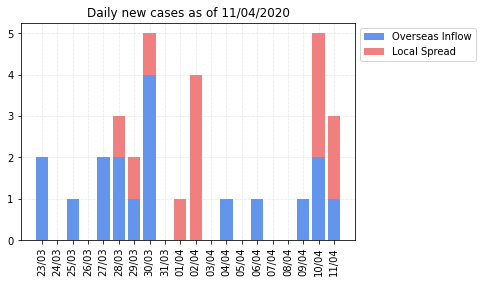

In [6]:
fig, ax = plt.subplots()
ax.grid(linestyle=':', linewidth='0.5', color='silver')
ax.set_axisbelow(True)


xindex = np.arange(len(pd.date_range(start=timeline_df.date.min(), end=pd.to_datetime("today").tz_localize("UTC").tz_convert("Asia/Yangon"))))


plt.xticks(xindex,pd.date_range(start=timeline_df.date.min(), end=pd.to_datetime("today").tz_localize("UTC").tz_convert("Asia/Yangon")).strftime('%d/%m'), fontsize=10, rotation=90)
plt.gca().yaxis.set_major_locator(mticker.MultipleLocator(1))

oi_case = plt.bar(xindex, timeline_df["overseas_inflow"], color = "cornflowerblue")
ls_case = plt.bar(xindex, timeline_df["local_spread"], bottom=timeline_df["overseas_inflow"], color = "lightcoral")

plt.title("Daily new cases as of "+str(pd.to_datetime("today").tz_localize("UTC").tz_convert("Asia/Yangon").strftime("%d/%m/%Y")))
plt.legend((oi_case[0],ls_case[0]), ("Overseas Inflow", "Local Spread"),loc='upper left', bbox_to_anchor=(1, 1))

new_cases = str(pd.to_datetime("today").tz_localize("UTC").tz_convert("Asia/Yangon").strftime("%d-%m-%Y"))+"_new_cases.svg"
plt.savefig(new_cases, bbox_inches = "tight")
plt.show()
files.download(new_cases)

In [7]:
exp_df = pd.DataFrame(columns=["ndays","date"])

exp_df["ndays"] = np.arange(len(pd.date_range(start=case_df.date.min(), end=pd.to_datetime("today").tz_localize("UTC").tz_convert("Asia/Yangon"))))
exp_df.loc[0,"date"]=case_df.date.min()
for i in range(1,len(exp_df)):
    exp_df.loc[i,"date"] = exp_df.loc[i-1,"date"] + pd.Timedelta(days=1)
    i=i+1
exp_df["date"] = pd.to_datetime(exp_df["date"])
exp_df=exp_df.merge(df.groupby(["exp_date"]).size().to_frame("expire"),left_on="date",right_on="exp_date",indicator=False,how='left')
exp_df["expire"].fillna(0, inplace=True)
exp_df["expire"]=exp_df["expire"].astype(int)
exp_df["total"]=exp_df["expire"].cumsum().astype(int)
exp_df

,ndays,date,expire,total
0,0,2020-03-23 00:00:00+06:30,0,0
1,1,2020-03-24 00:00:00+06:30,0,0
2,2,2020-03-25 00:00:00+06:30,0,0
3,3,2020-03-26 00:00:00+06:30,0,0
4,4,2020-03-27 00:00:00+06:30,0,0
5,5,2020-03-28 00:00:00+06:30,0,0
6,6,2020-03-29 00:00:00+06:30,0,0
7,7,2020-03-30 00:00:00+06:30,0,0
8,8,2020-03-31 00:00:00+06:30,1,1
9,9,2020-04-01 00:00:00+06:30,0,1


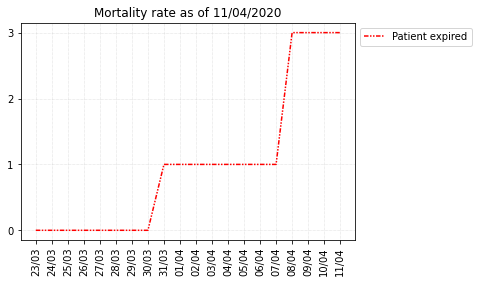

In [8]:
fig, ax = plt.subplots()
ax.grid(linestyle=':', linewidth='0.5', color='silver')
ax.set_axisbelow(True)


xindex = np.arange(len(pd.date_range(start=exp_df.date.min(), end=pd.to_datetime("today").tz_localize("UTC").tz_convert("Asia/Yangon"))))


plt.xticks(xindex,pd.date_range(start=exp_df.date.min(), end=pd.to_datetime("today").tz_localize("UTC").tz_convert("Asia/Yangon")).strftime('%d/%m'), fontsize=10, rotation=90)
plt.gca().yaxis.set_major_locator(mticker.MultipleLocator(1))

expire = plt.plot(xindex,exp_df["total"], linestyle=(0, (3, 1, 1, 1, 1, 1)), color="red")

plt.title("Mortality rate as of "+str(pd.to_datetime("today").tz_localize("UTC").tz_convert("Asia/Yangon").strftime("%d/%m/%Y")))
plt.legend((expire),("Patient expired",),loc='upper left', bbox_to_anchor=(1, 1))

exp_cases = str(pd.to_datetime("today").tz_localize("UTC").tz_convert("Asia/Yangon").strftime("%d-%m-%Y"))+"_exp.svg"
plt.savefig(exp_cases, bbox_inches = "tight")
plt.show()
files.download(exp_cases)

## Radar chart for underlying conditions of expired patients

In [9]:
mort_data = "https://raw.githubusercontent.com/finerbrighterlighter/myanmar_covid19/master/expired_underlying.csv"
mort_df = pd.read_csv(mort_data,header= 0)
mort_df

,case,date,underlying_con,ht_ds,dm,ht,ch_resp,ca
0,5,31/3/20,1,0,0,0,0,1
1,16,8/4/20,1,0,1,0,0,0
2,17,8/4/20,1,1,0,1,0,0


In [10]:
#mort_df.insert(loc=0, column="exp_id", value=np.arange(1,len(mort_df)+1))
#mort_df["exp_id"] = "exp_" + mort_df["exp_id"].astype(str)
mort_df.drop("case", axis=1 , inplace=True)
mort_df.drop("date", axis=1 , inplace=True)
mort_df.drop("underlying_con", axis=1 , inplace=True)
mort_df.ht_ds = mort_df.ht_ds.cumsum()
mort_df.dm = mort_df.dm.cumsum()
mort_df.ht = mort_df.ht.cumsum()
mort_df.ch_resp = mort_df.ch_resp.cumsum()
mort_df.ca = mort_df.ca.cumsum()
mort_df

,ht_ds,dm,ht,ch_resp,ca
0,0,0,0,0,1
1,0,1,0,0,1
2,1,1,1,0,1


In [11]:
Attributes =list(mort_df)
AttNo = len(Attributes)
Attributes

['ht_ds', 'dm', 'ht', 'ch_resp', 'ca']

In [0]:
values = mort_df.iloc[2].tolist()
values += values [:1]
values[:] = [x / len(mort_df) for x in values]

In [0]:
angles = [n / float(AttNo) * 2 * pi for n in range(AttNo)]
angles += angles [:1]

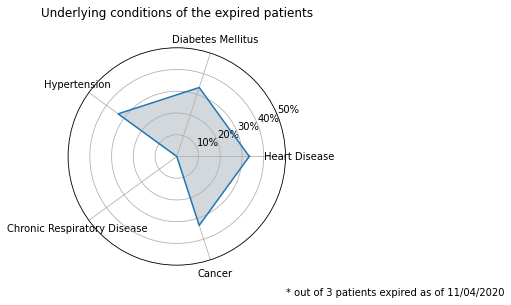

In [14]:
ax = plt.subplot(111, polar=True)

#Add the attribute labels to our axes
plt.xticks(angles[:-1],["Heart Disease", "Diabetes Mellitus", "Hypertension", "Chronic Respiratory Disease", "Cancer"])

plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(1,decimals=0))
plt.ylim(0, 0.5) 

#Plot the line around the outside of the filled area, using the angles and values calculated before
ax.plot(angles,values)

#Fill in the area plotted in the last line
ax.fill(angles, values, 'slategray', alpha=0.3)

#Give the plot a title and show it
ax.set_title("Underlying conditions of the expired patients", pad=20)
plt.text(1, -0.15, "* out of "+str(len(mort_df))+" patients expired as of "+str(pd.to_datetime("today").tz_localize("UTC").tz_convert("Asia/Yangon").strftime("%d/%m/%Y")), horizontalalignment="left", verticalalignment="bottom", transform=ax.transAxes)


under = str(pd.to_datetime("today").tz_localize("UTC").tz_convert("Asia/Yangon").strftime("%d-%m-%Y"))+"_underlying.svg"
plt.savefig(under, bbox_inches = "tight")
plt.show()
files.download(under)

In [15]:
dsc_df = pd.DataFrame(columns=["ndays","date"])

dsc_df["ndays"] = np.arange(len(pd.date_range(start=case_df.date.min(), end=pd.to_datetime("today").tz_localize("UTC").tz_convert("Asia/Yangon"))))
dsc_df.loc[0,"date"]=case_df.date.min()
for i in range(1,len(dsc_df)):
    dsc_df.loc[i,"date"] = dsc_df.loc[i-1,"date"] + pd.Timedelta(days=1)
    i=i+1
dsc_df["date"] = pd.to_datetime(dsc_df["date"])
dsc_df=dsc_df.merge(df.groupby(["dsc_date"]).size().to_frame("recovered"),left_on="date",right_on="dsc_date",indicator=False,how='left')
dsc_df["recovered"].fillna(0, inplace=True)
dsc_df["recovered"]=dsc_df["recovered"].astype(int)
dsc_df["total"]=dsc_df["recovered"].cumsum().astype(int)
dsc_df

,ndays,date,recovered,total
0,0,2020-03-23 00:00:00+06:30,0,0
1,1,2020-03-24 00:00:00+06:30,0,0
2,2,2020-03-25 00:00:00+06:30,0,0
3,3,2020-03-26 00:00:00+06:30,0,0
4,4,2020-03-27 00:00:00+06:30,0,0
5,5,2020-03-28 00:00:00+06:30,0,0
6,6,2020-03-29 00:00:00+06:30,0,0
7,7,2020-03-30 00:00:00+06:30,0,0
8,8,2020-03-31 00:00:00+06:30,0,0
9,9,2020-04-01 00:00:00+06:30,0,0


In [16]:
total_df = timeline_df[["date","total"]].copy()

total_df["expire"] = exp_df["total"]
total_df["recovered"] = dsc_df["total"]
total_df["hosp"] = (total_df["total"]-total_df["expire"]-total_df["recovered"])
total_df["expire"] = total_df["expire"]/total_df["total"]
total_df["recovered"] = total_df["recovered"]/total_df["total"]
total_df["hosp"] = total_df["hosp"]/total_df["total"]
total_df

,date,total,expire,recovered,hosp
0,2020-03-23 00:00:00+06:30,2,0.000000,0.000000,1.000000
1,2020-03-24 00:00:00+06:30,2,0.000000,0.000000,1.000000
2,2020-03-25 00:00:00+06:30,3,0.000000,0.000000,1.000000
3,2020-03-26 00:00:00+06:30,3,0.000000,0.000000,1.000000
4,2020-03-27 00:00:00+06:30,5,0.000000,0.000000,1.000000
5,2020-03-28 00:00:00+06:30,8,0.000000,0.000000,1.000000
6,2020-03-29 00:00:00+06:30,10,0.000000,0.000000,1.000000
7,2020-03-30 00:00:00+06:30,15,0.000000,0.000000,1.000000
8,2020-03-31 00:00:00+06:30,15,0.066667,0.000000,0.933333
9,2020-04-01 00:00:00+06:30,16,0.062500,0.000000,0.937500


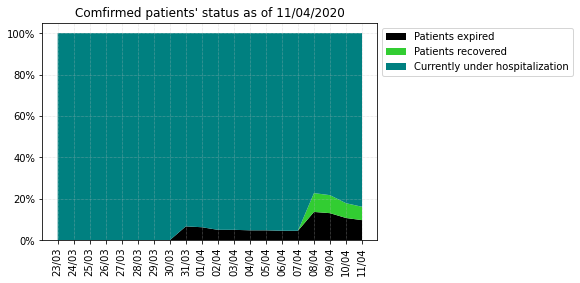

In [17]:
fig, ax = plt.subplots()
ax.grid(linestyle=':', linewidth='0.5', color='silver')


xindex = np.arange(len(pd.date_range(start=total_df.date.min(), end=pd.to_datetime("today").tz_localize("UTC").tz_convert("Asia/Yangon"))))


plt.xticks(xindex,pd.date_range(start=total_df.date.min(), end=pd.to_datetime("today").tz_localize("UTC").tz_convert("Asia/Yangon")).strftime('%d/%m'), fontsize=10, rotation=90)
plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(1.0))

local_spread = plt.stackplot(xindex,[total_df["expire"],total_df["recovered"],total_df["hosp"]],labels=["Patients expired","Patients recovered","Currently under hospitalization"],colors=["black","limegreen","teal"])

plt.title("Comfirmed patients' status as of "+str(pd.to_datetime("today").tz_localize("UTC").tz_convert("Asia/Yangon").strftime("%d/%m/%Y")))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

status = str(pd.to_datetime("today").tz_localize("UTC").tz_convert("Asia/Yangon").strftime("%d-%m-%Y"))+"_status.svg"
plt.savefig(status, bbox_inches = "tight")
plt.show()
files.download(status)

## Spread Trend

In [18]:
spread_trend_df = pd.DataFrame(columns=["ndays","date"])

spread_trend_df["ndays"] = np.arange(len(pd.date_range(start=case_df.date.min()-pd.Timedelta(days=5), end=pd.to_datetime("today").tz_localize("UTC").tz_convert("Asia/Yangon"))))
spread_trend_df.loc[0,"date"]=case_df.date.min()-pd.Timedelta(days=5)
for i in range(1,len(spread_trend_df)):
    spread_trend_df.loc[i,"date"] = spread_trend_df.loc[i-1,"date"] + pd.Timedelta(days=1)
    i=i+1
spread_trend_df["date"] = pd.to_datetime(spread_trend_df["date"])

spread_trend_df=spread_trend_df.merge(case_df,indicator=False,how='left')
spread_trend_df["overseas_inflow"].fillna(0, inplace=True)
spread_trend_df["local_spread"].fillna(0, inplace=True)
spread_trend_df["overseas_inflow"]=spread_trend_df["overseas_inflow"].astype(int)
spread_trend_df["local_spread"]=spread_trend_df["local_spread"].astype(int)
spread_trend_df["tot_overseas_inflow"]=spread_trend_df["overseas_inflow"].cumsum()
spread_trend_df["tot_local_spread"]=spread_trend_df["local_spread"].cumsum()
spread_trend_df

,ndays,date,overseas_inflow,local_spread,tot_overseas_inflow,tot_local_spread
0,0,2020-03-18 00:00:00+06:30,0,0,0,0
1,1,2020-03-19 00:00:00+06:30,0,0,0,0
2,2,2020-03-20 00:00:00+06:30,0,0,0,0
3,3,2020-03-21 00:00:00+06:30,0,0,0,0
4,4,2020-03-22 00:00:00+06:30,0,0,0,0
5,5,2020-03-23 00:00:00+06:30,2,0,2,0
6,6,2020-03-24 00:00:00+06:30,0,0,2,0
7,7,2020-03-25 00:00:00+06:30,1,0,3,0
8,8,2020-03-26 00:00:00+06:30,0,0,3,0
9,9,2020-03-27 00:00:00+06:30,2,0,5,0


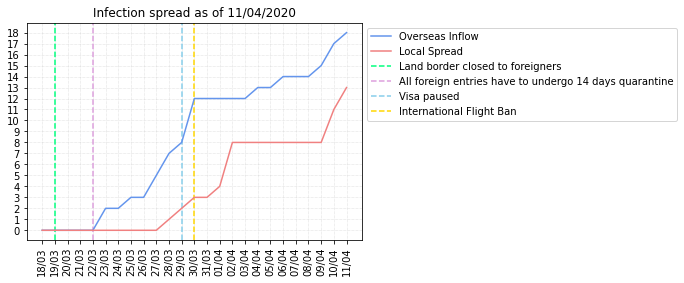

In [19]:
fig, ax = plt.subplots()
ax.grid(linestyle=':', linewidth='0.5', color='silver')
ax.set_axisbelow(True)


xindex = np.arange(len(pd.date_range(start=spread_trend_df.date.min(), end=pd.to_datetime("today").tz_localize("UTC").tz_convert("Asia/Yangon"))))

plt.xticks(xindex,pd.date_range(start=spread_trend_df.date.min(), end=pd.to_datetime("today").tz_localize("UTC").tz_convert("Asia/Yangon")).strftime('%d/%m'), fontsize=10, rotation=90)
plt.gca().yaxis.set_major_locator(mticker.MultipleLocator(1))

land_close_fore = plt.axvline(x=1, color="springgreen", linestyle="--")
com_qua = plt.axvline(x=4, color="plum", linestyle="--")
visa_close = plt.axvline(x=11, color="skyblue", linestyle="--")
air_close = plt.axvline(x=12, color="gold", linestyle="--")
overseas_inflow = plt.plot(xindex, spread_trend_df["tot_overseas_inflow"], color="cornflowerblue")
local_spread = plt.plot(xindex, spread_trend_df["tot_local_spread"], color="lightcoral")

plt.title("Infection spread as of "+str(pd.to_datetime("today").tz_localize("UTC").tz_convert("Asia/Yangon").strftime("%d/%m/%Y")))
plt.legend((overseas_inflow[0],local_spread[0],land_close_fore,com_qua,visa_close,air_close), ("Overseas Inflow", "Local Spread","Land border closed to foreigners","All foreign entries have to undergo 14 days quarantine","Visa paused","International Flight Ban"),loc='upper left', bbox_to_anchor=(1, 1))

spread = str(pd.to_datetime("today").tz_localize("UTC").tz_convert("Asia/Yangon").strftime("%d-%m-%Y"))+"_spread.svg"
plt.savefig(spread, bbox_inches = "tight")
plt.show()
files.download(spread)

# Per Patient Timeline

In [20]:
timeline_df = pd.DataFrame(columns=["case_id"])
timeline_df["case_id"] = df["case_id"]
timeline_df["until_qua"] = (df["qua_date"]-df["first_date"]).dt.days
timeline_df["until_ann"] = (df["ann_date"]-df["qua_date"]).dt.days
timeline_df["until_first"] = (df["first_date"]-df["first_date"].min()).dt.days
timeline_df["until_exp"] = np.where(df["exp_date"].notna(), (df["exp_date"]-df["ann_date"]).dt.days, 0)
timeline_df["until_dsc"] = np.where(df["dsc_date"].notna(), (df["dsc_date"]-df["ann_date"]).dt.days, 0)
timeline_df["cur_hosp"] = np.where(df["exp_date"].isna(), np.where(df["dsc_date"].isna(), (pd.to_datetime("today").tz_localize("UTC").tz_convert("Asia/Yangon")-df["ann_date"]).dt.days, 0), 0)
timeline_df

,case_id,until_qua,until_ann,until_first,until_exp,until_dsc,cur_hosp
0,case_1,6,2,1,0.0,0.0,19
1,case_2,1,0,8,0.0,0.0,19
2,case_3,2,2,7,0.0,0.0,17
3,case_4,6,2,5,0.0,12.0,0
4,case_5,11,2,0,4.0,0.0,0
5,case_6,5,2,7,0.0,0.0,14
6,case_7,8,2,4,0.0,11.0,0
7,case_8,1,2,11,0.0,0.0,14
8,case_9,3,3,9,0.0,0.0,13
9,case_10,0,1,14,0.0,0.0,13


##Timeline for each patient(Bar Plot)

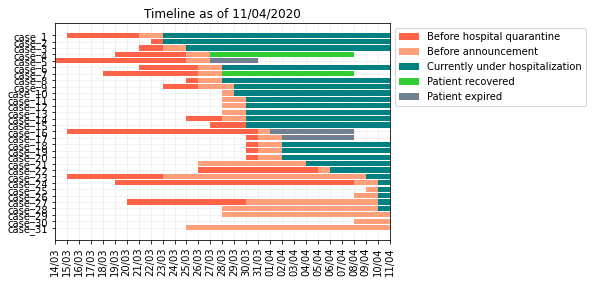

In [21]:
fig, ax = plt.subplots()
ax.grid(linestyle=':', linewidth='0.5', color='silver')
ax.set_axisbelow(True)

yindex = np.arange(len(timeline_df["case_id"]))

xindex = np.arange(len(pd.date_range(start=df.first_date.min(), end=pd.to_datetime("today").tz_localize("UTC").tz_convert("Asia/Yangon"))))

plt.yticks(yindex,timeline_df["case_id"], fontsize=10)

plt.xticks(xindex,pd.date_range(start=df.first_date.min(), end=pd.to_datetime("today").tz_localize("UTC").tz_convert("Asia/Yangon")).strftime('%d/%m'), fontsize=10, rotation=90)
plt.gca().invert_yaxis()

until_qua = plt.barh(yindex, timeline_df["until_qua"], left= timeline_df["until_first"], color = "tomato")
until_ann = plt.barh(yindex, timeline_df["until_ann"], left= timeline_df["until_qua"]+timeline_df["until_first"], color = "lightsalmon")
until_exp = plt.barh(yindex, timeline_df["until_exp"], left= timeline_df["until_ann"]+timeline_df["until_qua"]+timeline_df["until_first"], color = "slategray")
until_dsc = plt.barh(yindex, timeline_df["until_dsc"], left= timeline_df["until_exp"]+timeline_df["until_ann"]+timeline_df["until_qua"]+timeline_df["until_first"], color = "limegreen")
cur_hosp = plt.barh(yindex, timeline_df["cur_hosp"], left= timeline_df["until_dsc"]+timeline_df["until_exp"]+timeline_df["until_ann"]+timeline_df["until_qua"]+timeline_df["until_first"], color = "teal")

plt.title("Timeline as of "+str(pd.to_datetime("today").tz_localize("UTC").tz_convert("Asia/Yangon").strftime("%d/%m/%Y")))
plt.legend((until_qua[0], until_ann[0],cur_hosp[0],until_dsc[0],until_exp[0]), ("Before hospital quarantine", "Before announcement","Currently under hospitalization","Patient recovered","Patient expired"),loc='upper left', bbox_to_anchor=(1, 1))

timeline = str(pd.to_datetime("today").tz_localize("UTC").tz_convert("Asia/Yangon").strftime("%d-%m-%Y"))+"_timeline.svg"
plt.savefig(timeline, bbox_inches = "tight")
plt.show()
files.download(timeline)

##Time taken for action (Bar Plot)

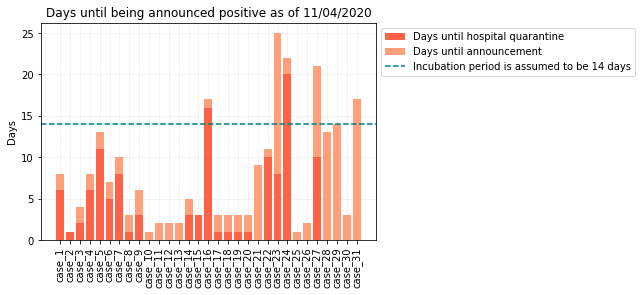

In [22]:
fig, ax = plt.subplots()
ax.grid(linestyle=':', linewidth='0.5', color='silver')
ax.set_axisbelow(True)

index = np.arange(len(timeline_df["case_id"]))

incub = plt.axhline(y=14, color="teal", linestyle="--")
p1 = plt.bar(index, timeline_df["until_qua"], color = "tomato")
p2 = plt.bar(index, timeline_df["until_ann"], bottom=timeline_df["until_qua"], color = "lightsalmon")

plt.ylabel("Days", fontsize=10)
plt.title("Days until being announced positive as of "+str(pd.to_datetime("today").tz_localize("UTC").tz_convert("Asia/Yangon").strftime("%d/%m/%Y")))
plt.xticks(index,timeline_df["case_id"], fontsize=10, rotation=90)
plt.legend((p1[0], p2[0],incub), ("Days until hospital quarantine", "Days until announcement","Incubation period is assumed to be 14 days"),loc="upper left", bbox_to_anchor=(1, 1))

days = str(pd.to_datetime("today").tz_localize("UTC").tz_convert("Asia/Yangon").strftime("%d-%m-%Y"))+"_time_for_action.svg"
plt.savefig(days, bbox_inches = "tight")
plt.show()
files.download(days)

# Exponential Growth

In [23]:
sum_df = df[["ann_date","case_id"]].copy()
sum_df.columns = ["Date", "id"]
sum_df=sum_df.groupby(["Date"]).size().to_frame("Case").reset_index()
sum_df["Date"] = pd.to_datetime(sum_df["Date"])
sum_df

,Date,Case
0,2020-03-23 00:00:00+06:30,2
1,2020-03-25 00:00:00+06:30,1
2,2020-03-27 00:00:00+06:30,2
3,2020-03-28 00:00:00+06:30,3
4,2020-03-29 00:00:00+06:30,2
5,2020-03-30 00:00:00+06:30,5
6,2020-04-01 00:00:00+06:30,1
7,2020-04-02 00:00:00+06:30,4
8,2020-04-04 00:00:00+06:30,1
9,2020-04-06 00:00:00+06:30,1


In [24]:
confirmed_df = pd.DataFrame(columns=["ndays","Date"])
#confirmed_df["ndays"] = np.arange(len(pd.date_range(start=sum_df.Date.min(), end=sum_df.Date.max())))
confirmed_df["ndays"] = np.arange(len(pd.date_range(start=sum_df.Date.min(), end=pd.to_datetime("today").tz_localize("UTC").tz_convert("Asia/Yangon"))))
confirmed_df.loc[0,"Date"]=sum_df.Date.min()
for i in range(1,len(confirmed_df)):
    confirmed_df.loc[i,"Date"] = confirmed_df.loc[i-1,"Date"] + pd.Timedelta(days=1)
    i=i+1
confirmed_df["Date"] = pd.to_datetime(confirmed_df["Date"])
confirmed_df=confirmed_df.merge(sum_df,indicator=False,how='left')
confirmed_df["Case"].fillna(0, inplace=True)
confirmed_df["Case"]=confirmed_df["Case"].astype(int)
confirmed_df["Case"] = confirmed_df["Case"].cumsum()

# Natural Log of Real Cases
confirmed_df["logCase"] = np.log(confirmed_df.Case).astype(float)
confirmed_df

,ndays,Date,Case,logCase
0,0,2020-03-23 00:00:00+06:30,2,0.693147
1,1,2020-03-24 00:00:00+06:30,2,0.693147
2,2,2020-03-25 00:00:00+06:30,3,1.098612
3,3,2020-03-26 00:00:00+06:30,3,1.098612
4,4,2020-03-27 00:00:00+06:30,5,1.609438
5,5,2020-03-28 00:00:00+06:30,8,2.079442
6,6,2020-03-29 00:00:00+06:30,10,2.302585
7,7,2020-03-30 00:00:00+06:30,15,2.708050
8,8,2020-03-31 00:00:00+06:30,15,2.708050
9,9,2020-04-01 00:00:00+06:30,16,2.772589


Natural log makes it better in terms of visualization and long term comparison, make the data look more linear. That is why I will be plotting both real and natural log line graphs.

# Model of choice

True exponential does not exist, but exponential growth is assumed until the inflection point has arrived. Linear Regression is applied.

## Logistic Regression
### Ordinary Least Squared Regression

In [25]:
X = confirmed_df.ndays
X = sm.add_constant(X)
y = confirmed_df.logCase
model = sm.OLS(y, X)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                logCase   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     91.92
Date:                Sat, 11 Apr 2020   Prob (F-statistic):           1.70e-08
Time:                        13:49:13   Log-Likelihood:                -7.8519
No. Observations:                  20   AIC:                             19.70
Df Residuals:                      18   BIC:                             21.70
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1170      0.163      6.862      0.000       0.775       1.459
ndays          0.1404      0.015      9.587      0.000       0.110       0.171
==============================================================================
Omnibus:                        6.219   Durbin-Watson:                   0.224
Prob(Omnibus):                  0.045   Jarque-Bera (JB):                1.709
Skew:                           0.099   Prob(JB):                        0.425
Kurtosis:                       1.582   Cond. No.                         21.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Exponential Formaula<br> y = ab<sup>x</sup> <br>
a = Initial Value<br>
b = Rate of Change<br>
x = The feature ( Here it is time )<br>

b = (1+r) = Growth Rate <- Before Inflection <br>
b = (1-r) = Decay Rate <- After Inflection <br>

In the summary, "constant stands" for initial "a".<br>
"ndays" is the coefficient of "time", which means the value increasing y as x is increased by 1. In our case, the number of cases to increase as the next day comes.

In [0]:
def linear_predictions(t):
    return np.exp(result.params["const"]) * np.exp(result.params["ndays"]) ** t

As we fitted our model with natural log values, we should change them back to real numbers to predict.

# Next Week Prediction

In [27]:
ndays = len(confirmed_df)+7
nextweek_df = pd.DataFrame(columns=["ndays","Date"])
nextweek_df["ndays"] = np.arange(ndays)
nextweek_df.loc[0,"Date"]=confirmed_df.loc[0,"Date"]
for i in range(1,len(nextweek_df)):
    nextweek_df.loc[i,"Date"] = nextweek_df.loc[i-1,"Date"] + pd.Timedelta(days=1)
    i=i+1
nextweek_df["Predictions"] = nextweek_df.ndays.apply(linear_predictions)

# Natural Log of Predicted Cases
nextweek_df["logPredictions"] = np.log(nextweek_df.Predictions).astype(float)

nextweek_df

,ndays,Date,Predictions,logPredictions
0,0,2020-03-23 00:00:00+06:30,3.055543,1.116957
1,1,2020-03-24 00:00:00+06:30,3.516189,1.257378
2,2,2020-03-25 00:00:00+06:30,4.046280,1.397798
3,3,2020-03-26 00:00:00+06:30,4.656286,1.538218
4,4,2020-03-27 00:00:00+06:30,5.358255,1.678638
5,5,2020-03-28 00:00:00+06:30,6.166051,1.819059
6,6,2020-03-29 00:00:00+06:30,7.095629,1.959479
7,7,2020-03-30 00:00:00+06:30,8.165346,2.099899
8,8,2020-03-31 00:00:00+06:30,9.396332,2.240319
9,9,2020-04-01 00:00:00+06:30,10.812898,2.380740


Although I stated next week, here I added only "3". Since our data and history is very short right now, it is not sufficient to predict far without sacraficing. This currently here is a proof of concept. We shall increase the data and after that, we should pursure further analysis.

# Real Number Plot

In [0]:
real = str(pd.to_datetime("today").strftime("%d-%m-%Y"))+"_real.svg"
log = str(pd.to_datetime("today").strftime("%d-%m-%Y"))+"_log.svg"

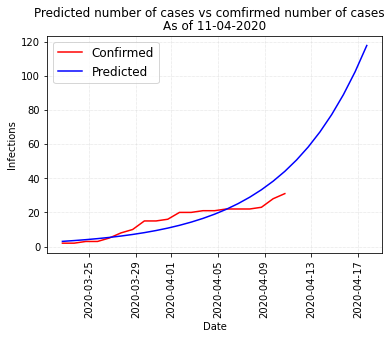

In [29]:
confirmed_x = pd.date_range(start=confirmed_df["Date"][confirmed_df.index[0]], end=confirmed_df["Date"][confirmed_df.index[-1]])
confirmed_y = confirmed_df["Case"].tolist()
confirmed_plot = pd.Series(data=confirmed_y, index=confirmed_x)

nextweek_x = pd.date_range(start=nextweek_df["Date"][nextweek_df.index[0]], end=nextweek_df["Date"][nextweek_df.index[-1]])
nextweek_y = nextweek_df["Predictions"].tolist()
nextweek_plot = pd.Series(data=nextweek_y, index=nextweek_x)

fig, ax = plt.subplots()
ax.plot(confirmed_plot, label="Confirmed", color="red")
ax.plot(nextweek_plot, label="Predicted", color ="blue")
ax.grid(linestyle=':', linewidth='0.5', color='silver')
ax.set_axisbelow(True)

legend = ax.legend(loc="upper left", fontsize="large")
plt.xlabel("Date")
plt.ylabel("Infections")
plt.suptitle("Predicted number of cases vs comfirmed number of cases")
plt.title("As of "+str(pd.to_datetime("today").strftime("%d-%m-%Y")))
plt.xticks(rotation=90)
plt.savefig(real, bbox_inches = "tight")
plt.show()
files.download(real)

# Natural Log Plot

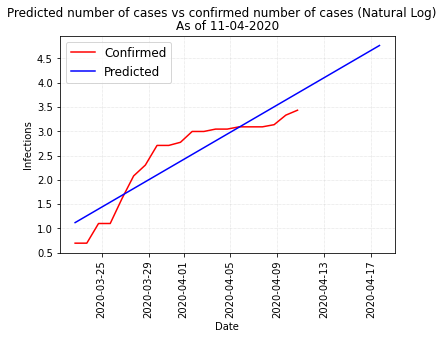

In [30]:
confirmed_logy = confirmed_df["logCase"].tolist()
confirmed_logplot = pd.Series(data=confirmed_logy, index=confirmed_x)

nextweek_logy = nextweek_df["logPredictions"].tolist()
nextweek_logplot = pd.Series(data=nextweek_logy, index=nextweek_x)

fig, ax = plt.subplots()
ax.plot(confirmed_logplot, label="Confirmed", color="red")
ax.plot(nextweek_logplot, label="Predicted", color ="blue")
ax.grid(linestyle=':', linewidth='0.5', color='silver')
ax.set_axisbelow(True)

legend = ax.legend(loc="upper left", fontsize="large")
plt.xlabel("Date")
plt.ylabel("Infections")
plt.suptitle("Predicted number of cases vs confirmed number of cases (Natural Log)")
plt.title("As of "+str(pd.to_datetime("today").strftime("%d-%m-%Y")))
plt.xticks(rotation=90)
plt.savefig(log, bbox_inches = "tight")
plt.show()
files.download(log)

In [31]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? n
Nothing done.
